## ODE system:

$$\frac{d}{dt} N_1(t) = - F \cdot N_1(t) \cdot \frac{1}{T_1} + source_1(t)$$

$$\frac{d}{dt} N_2(t) = G \cdot N_1(t) \cdot \frac{1}{T_1} + H \cdot N_2(t) \cdot \frac{1}{T_2} - N_2(t) \cdot \frac{1}{T_2'}$$

$$\frac{d}{dt} N_3(t) = \frac{1 - H}{2} \cdot N_2(t) \cdot \frac{1}{T_2} - N_3(t) \cdot \frac{1}{T_3}$$

$$\frac{d}{dt} N_4(t) = \frac{1 - H}{2} \cdot N_2(t) \cdot \frac{1}{T_2} - N_4(t) \cdot \frac{1}{T_4}$$

$$\frac{d}{dt} N_5(t) = c_2 \cdot N_2(t) + c_3 \cdot N_3(t) + source_5(t) - N_5(t) \cdot (\frac{2r-r^2}{T_5} + \frac{1}{T'_5})$$

$$\frac{d}{dt} N_6(t) = source_6(t) - N_6(t) \cdot (\frac{1}{T_5} + \frac{1}{T_6}) + (L + r' \cdot R) \cdot \frac{1}{T_5}$$

In [160]:
import numpy as np
from scipy.integrate import ode
import sympy as sym

#### Consts

In [161]:
T_1 = 10
T_2 = 10
T_3 = 20
T_4 = 1e4
T_5 = 5
T_6 = 20
T_2_str = 1e3
T_5_str = 500
N_min = 1e-23
k = 1e6
k_str = 1e6
m = 1e3
c2 = 4*1e6
c3 = 4*1e6

#### Initital conditions

$$x(t) = [N_1(t), N_2(t), N_3(t), N_4(t), N_5(t), N_6(t)]$$

In [162]:
x_init = np.array([1e-20, 0, 0, 0, 0, 1e-6])

#### Equation for param L

$$N_6(t) = L \cdot (1 + \frac{2kN_5(t)}{1 + kL} + \frac{k' \cdot m \cdot (N_1(t) + N_2(t) + N_4(t))}{1 + k' \cdot L})$$

$$N_6 \cdot (1 + k \cdot L) \cdot (1 + k' \cdot L) = L \cdot ((1 + k \cdot L) \cdot (1 + k' \cdot L) + 2kN_5 \cdot (1 + k' \cdot L) + k' \cdot m \cdot (N_1 + N_2 + N_4) \cdot (1 + k \cdot L))$$

$$kk'N_6 \cdot L^2 + (k + k')N_6 \cdot L + N_6 = kk' \cdot L^3 + (k + k') \cdot L^2 + L + 2kk'N_5 \cdot L^2 + 2kN_5 \cdot L + kk'm(N1 + N2+ N4) \cdot L^2 + k'm(N1 + N2 + N4) \cdot L $$

$$a \cdot L^3 + b \cdot L^2 + c \cdot L + d = 0 \text{ where} $$ 

$$a = kk' \quad b = (k + k') + 2kk'N_5 + kk'm(N1 + N2+ N4) - kk'N_6 \quad c = 1 + 2kN_5 + k'm(N1 + N2 + N4) - (k + k')N_6 \quad d = - N_6$$

$$a = kk' \quad b = (k + k') + kk'(2N_5 + m(N1 + N2+ N4) - N_6) \quad c = 1 + 2kN_5 + k'm(N1 + N2 + N4) - (k + k')N_6 \quad d = - N_6$$

In [163]:
def L_f(x):

    [N1, N2, N3, N4, N5, N6] = x

    a = k * k_str
    b = (k + k_str) + k * k_str * (2 * N5 + m * (N1 + N2 + N4) - N6)
    c = 1 + 2 * k * N5 + k_str * m * (N1 + N2 + N4) - (k + k_str) * N6
    d = -N6

    coeffs = [a, b, c, d]
    # L = sym.symbols('L')
    #  solutions = list(sym.solveset(a * L**3 + b * L**2 + c * L + d, L, sym.S.Reals))
    solutions = [s for s in np.roots(coeffs) if np.isreal(s) and s > 0 and s < N6]
    print(np.real(solutions))
    return max(np.real(solutions))
    
    

### Params:

$$r = \frac{k \cdot L}{1 + k \cdot L} \quad r' = \frac{k' \cdot L}{1 + k' \cdot L} \quad R = m \cdot (N_1(t) + N_2(t) + N_4(t)) \quad R' = m \cdot r'$$

$$F = \frac{R'}{1 + R'} \quad G = (1-r') \cdot F \quad H = \frac{R' - 1}{R' + 1}$$

In [164]:
def r_f(L):
    return (k * L) / (1 + k * L)


def r_str_f(L):
    return (k_str * L) / (1 + k_str * L)


def R_f(x):
    [N1, N2, N3, N4, N5, N6] = x
    return m * (N1 + N2 + N4)


def R_str_f(r_str):
    return m * r_str


def F_f(R_str):
    return R_str / (1 + R_str)


def G_f(r_str, F):
    return (1 - r_str) * F


def H_f(R_str):
    return (R_str - 1) / (R_str + 1)

#### Time derivative

$$\frac{d}{dt} x = f(x)

In [165]:
def f(t, x):
    
    [N1, N2, N3, N4, N5, N6] = x

    L = L_f(x)
    r = r_f(L)
    r_str = r_str_f(L)
    R = R_f(x)
    R_str = R_str_f(r_str)
    F = F_f(R_str)
    G = G_f(r_str, F)
    H = H_f(R_str)

    dN1_dt = -F * N1 / T_1
    dN2_dt = G * N1 / T_1 + H * N2 / T_2 - N2 / T_2_str
    dN3_dt = (1 - H) / 2 * N2 / T_2 - N3 / T_3
    dN4_dt = (1 - H) / 2 * N2 / T_2 - N4 / T_4
    dN5_dt = c2 * N2 + c3 * N3 - N5 * ((2 * r - r**2) / T_5 + 1 / T_5_str)
    dN6_dt = -N6 * (1 / T_5 + 1 / T_6) + (L + r_str * R) / T_5

    return np.array([dN1_dt, dN2_dt, dN3_dt, dN4_dt, dN5_dt, dN6_dt])



In [166]:
t_0 = 0
t_1 = 310
step = 1

integrator = ode(f).set_integrator('dopri5').set_initial_value(x_init, t_0)

flag = True
t = []
x = []
L_list = []
while integrator.successful() and integrator.t < t_1:
    integrator.integrate(integrator.t + step)
    [N1, N2, N3, N4, N5, N6] = integrator.y
    if (flag  and N1 < 1e-25):
        N1 = 0
        flag = False
        integrator.set_initial_value([N1, N2, N3, N4, N5, N6], integrator.t)
    t.append(integrator.t)
    x.append(integrator.y)
    L_list.append(L_f(integrator.y))

[1.e-06]
[9.9e-07]
[9.99474694e-07]
[9.99212352e-07]
[9.97900982e-07]
[9.97668028e-07]
[9.97376915e-07]
[9.97376918e-07]
[9.92137642e-07]
[9.89548966e-07]
[9.76637099e-07]
[9.74356741e-07]
[9.71517639e-07]
[9.71521571e-07]
[9.67420158e-07]
[9.6538893e-07]
[9.55252974e-07]
[9.53460879e-07]
[9.5122744e-07]
[9.51229423e-07]
[9.51229423e-07]
[9.51229423e-07]
[9.41717129e-07]
[9.37067995e-07]
[9.13922203e-07]
[9.09850273e-07]
[9.0481128e-07]
[9.04837414e-07]
[9.04837414e-07]
[9.04837414e-07]
[8.95789039e-07]
[8.91366646e-07]
[8.69349687e-07]
[8.65476347e-07]
[8.60683108e-07]
[8.60707967e-07]
[8.60707967e-07]
[8.60707967e-07]
[8.52100887e-07]
[8.47894176e-07]
[8.26950995e-07]
[8.2326656e-07]
[8.1870709e-07]
[8.18730737e-07]
[8.18730737e-07]
[8.18730737e-07]
[8.10543428e-07]
[8.06541881e-07]
[7.8662011e-07]
[7.83115367e-07]
[7.78778265e-07]
[7.78800758e-07]
[7.78800758e-07]
[7.78800758e-07]
[7.71012749e-07]
[7.67206359e-07]
[7.48256183e-07]
[7.44922368e-07]
[7.40796788e-07]
[7.40818185e-07]
[

C:\Users\king choco\AppData\Local\Temp\ipykernel_7508\4209786570.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t, np.log10([row[i] for row in x]), label=f'N{i+1}')


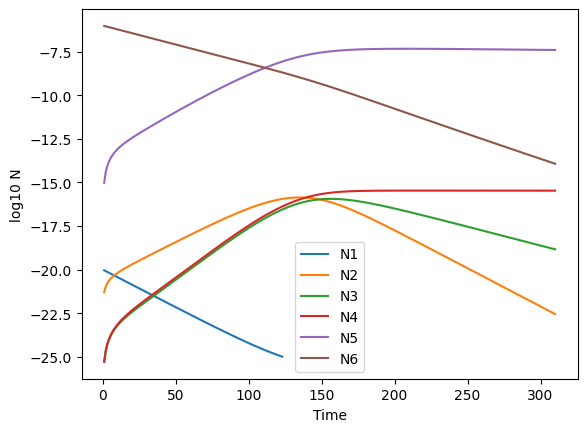

In [167]:
import matplotlib.pyplot as plt

# Создаем график
fig, ax = plt.subplots()

# Добавляем данные на график
for i in range(len(x[0])):
    ax.plot(t, np.log10([row[i] for row in x]), label=f'N{i+1}')

# Добавляем легенду и подписи осей
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('log10 N')

# Отображаем график
plt.show()

Text(0, 0.5, 'L')

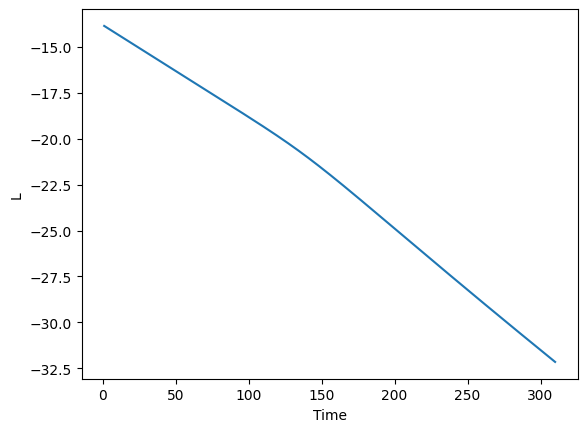

In [168]:
plt.plot(t, np.log(L_list))

plt.xlabel('Time')
plt.ylabel('L')